<a id="1"></a>
# **<center><span style="color:black;">Setup and Initialization</span></center>**

In [2]:
import math
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras
# from tqdm import tqdm
from keras.callbacks import EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import glob
import pandas as pan
import matplotlib.pyplot as plotter
import warnings
warnings.filterwarnings('ignore')

<a id="2"></a>
# **<center><span style="color:black;">Read Dataset</span></center>**

Upload the zip file for the dataset in your Drive in order to execute the code, else keep in the same directory as the ipynb file and change the paths accordingly.

In [6]:
#Create Files_Name
image_data= 'dataset2\garbage_classification' #change according to your dataset path
pd.DataFrame(os.listdir(image_data),columns=['Files_Name'])

,Files_Name
0,battery
1,biological
2,brown-glass
3,cardboard
4,clothes
5,green-glass
6,metal
7,paper
8,plastic
9,shoes


In [7]:
files = [i for i in glob.glob(image_data + "//*//*")]
np.random.shuffle(files)
labels = [os.path.dirname(i).split("/")[-1] for i in files]
data = zip(files, labels)
dataframe = pan.DataFrame(data, columns = ["Image", "Label"])
dataframe

,Image,Label
0,dataset2\garbage_classification\paper\paper761...,dataset2\garbage_classification\paper
1,dataset2\garbage_classification\brown-glass\br...,dataset2\garbage_classification\brown-glass
2,dataset2\garbage_classification\brown-glass\br...,dataset2\garbage_classification\brown-glass
3,dataset2\garbage_classification\clothes\clothe...,dataset2\garbage_classification\clothes
4,dataset2\garbage_classification\trash\trash14.jpg,dataset2\garbage_classification\trash
...,...,...
15510,dataset2\garbage_classification\clothes\clothe...,dataset2\garbage_classification\clothes
15511,dataset2\garbage_classification\clothes\clothe...,dataset2\garbage_classification\clothes
15512,dataset2\garbage_classification\clothes\clothe...,dataset2\garbage_classification\clothes
15513,dataset2\garbage_classification\white-glass\wh...,dataset2\garbage_classification\white-glass


<a id="3"></a>
# **<center><span style="color:black;">Exploratory Data Analysis (EDA)</span></center>**

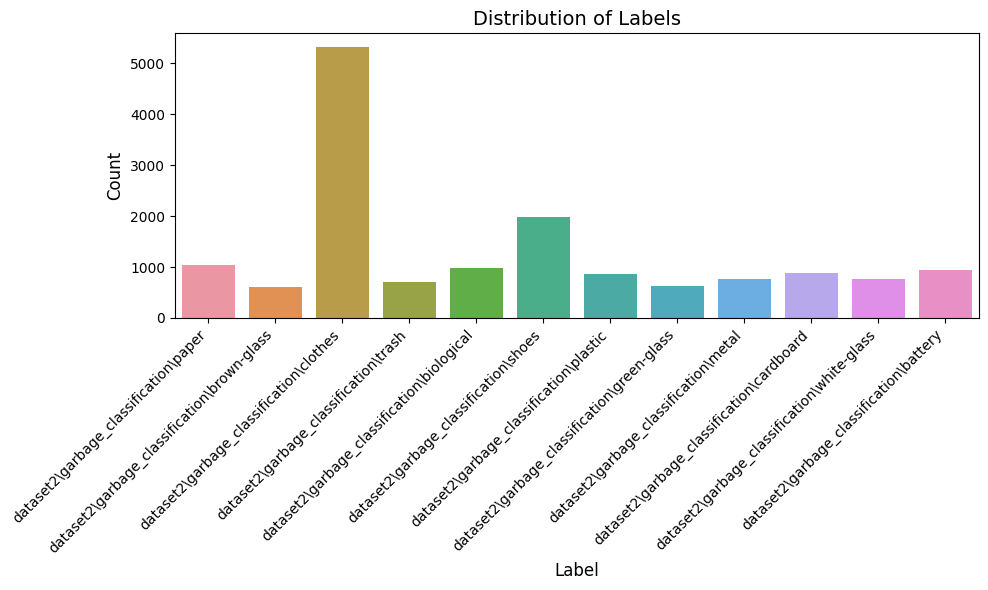

In [8]:
plt.figure(figsize=(10, 6))
sns.countplot(x=dataframe["Label"])
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Label", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Labels", fontsize=14)
plt.tight_layout()
plt.show()


In [9]:

# Display some statistics about the dataset
num_classes = len(dataframe["Label"].unique())
total_samples = len(dataframe)
class_counts = dataframe["Label"].value_counts()

print("Number of classes:", num_classes)
print("Total number of samples:", total_samples)
print("Class-wise distribution:")
print(class_counts)


Number of classes: 12
Total number of samples: 15515
Class-wise distribution:
dataset2\garbage_classification\clothes        5325
dataset2\garbage_classification\shoes          1977
dataset2\garbage_classification\paper          1050
dataset2\garbage_classification\biological      985
dataset2\garbage_classification\battery         945
dataset2\garbage_classification\cardboard       891
dataset2\garbage_classification\plastic         865
dataset2\garbage_classification\white-glass     775
dataset2\garbage_classification\metal           769
dataset2\garbage_classification\trash           697
dataset2\garbage_classification\green-glass     629
dataset2\garbage_classification\brown-glass     607
Name: Label, dtype: int64


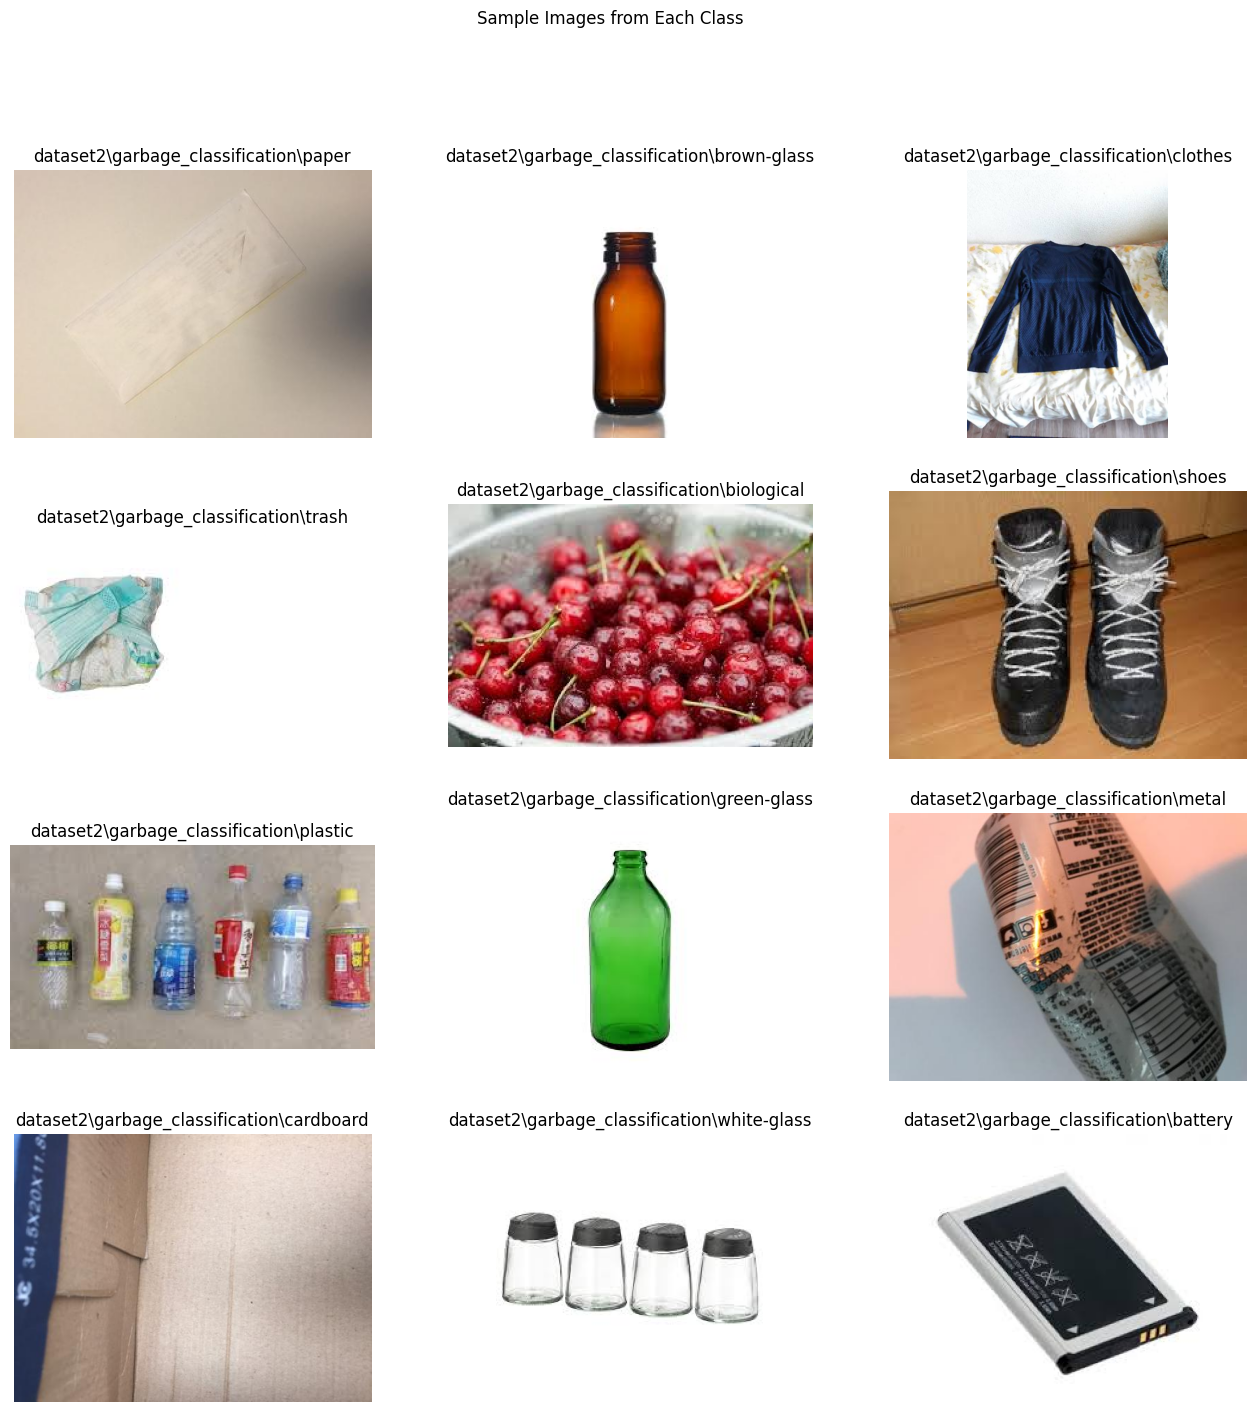

In [10]:
# Calculate the number of rows and columns for the subplot grid
num_labels = len(dataframe["Label"].unique())
num_cols = 3
num_rows = math.ceil(num_labels / num_cols)

# Display sample images from each class
plt.figure(figsize=(16, 16))
for i, label in enumerate(dataframe["Label"].unique()):
    plt.subplot(num_rows, num_cols, i+1)
    sample_img_path = dataframe[dataframe["Label"] == label]["Image"].iloc[0]
    sample_img = plt.imread(sample_img_path)
    plt.imshow(sample_img)
    plt.title(label)
    plt.axis('off')
plt.suptitle("Sample Images from Each Class")
plt.show()



<a id="4"></a>
# **<center><span style="color:black;">Stratified Data Splitting: Train & Validation</span></center>**

In [11]:
train_data_dir =image_data
batch_size = 128
target_size = (224,224)
validation_split = 0.2

In [12]:

train= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="training",
    seed=50,
    image_size=target_size,
    batch_size=batch_size,
)
validation= tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    validation_split=validation_split,
    subset="validation",
    seed=100,
    image_size=target_size,
    batch_size=batch_size,
)

Found 15515 files belonging to 12 classes.
Using 12412 files for training.
Found 15515 files belonging to 12 classes.
Using 3103 files for validation.


In [13]:
class_names = train.class_names
class_names

['battery',
 'biological',
 'brown-glass',
 'cardboard',
 'clothes',
 'green-glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash',
 'white-glass']

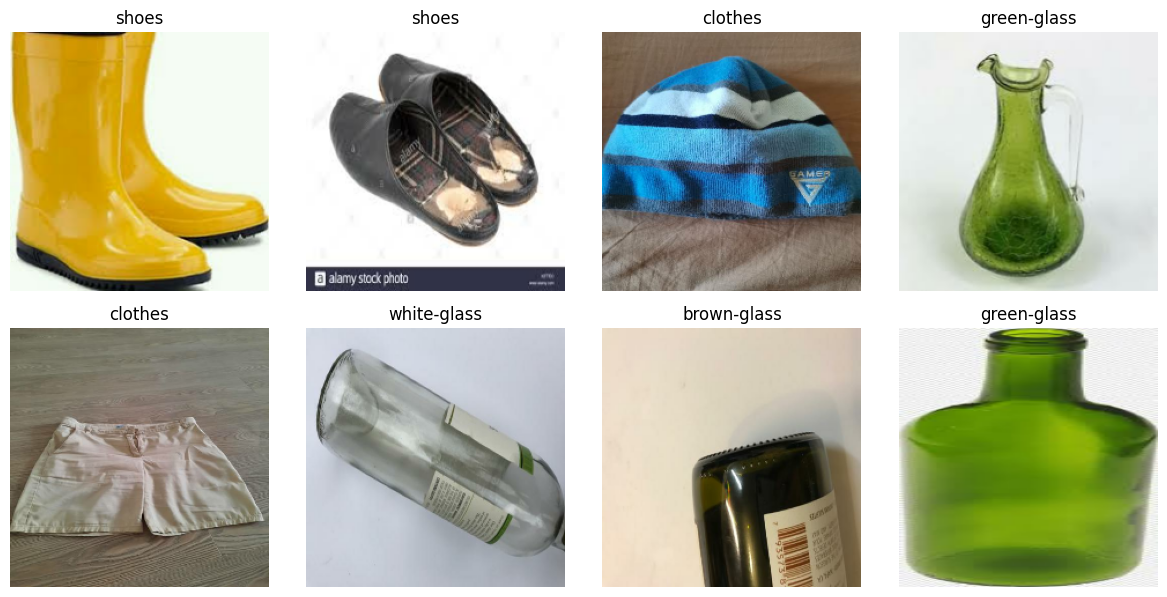

In [14]:
# Displaying some of the images from train data set
plt.figure(figsize=(12, 12))
for images, labels in train.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=12)
        plt.axis("off")
plt.tight_layout()
plt.show()


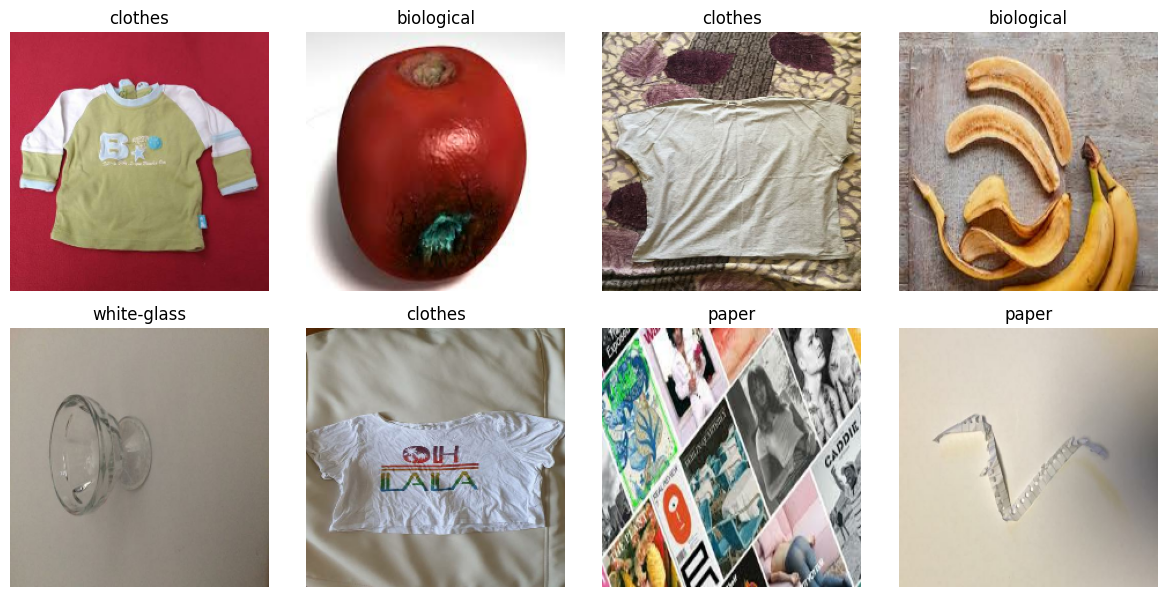

In [15]:
# Displaying some of the images from validation data set
plt.figure(figsize=(12, 12))
for images, labels in validation.take(1):
    for i in range(8):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]], fontsize=12)
        plt.axis("off")
plt.tight_layout()
plt.show()


<a id="5"></a>
# **<center><span style="color:black;">Loading EfficientNet with Pre-trained Weights</span></center>**

In [16]:
base_model = tf.keras.applications.EfficientNetV2B1(input_shape=(224,224,3),include_top=False,weights='imagenet')
base_model.trainable = False
keras_model=keras.models.Sequential()
keras_model.add(base_model)
keras_model.add(keras.layers.Flatten())
keras_model.add(keras.layers.Dropout(0.5))
keras_model.add(keras.layers.Dense(12,activation=tf.nn.softmax))     #12 classes
keras_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-b1 (Function  (None, 7, 7, 1280)       6931124   
 al)                                                             
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dropout (Dropout)           (None, 62720)             0         
                                                                 
 dense (Dense)               (None, 12)                752652    
                                                                 
Total params: 7,683,776
Trainable params: 752,652
Non-trainable params: 6,931,124
_________________________________________________________________


In [17]:
tf.keras.utils.plot_model(keras_model, to_file='model.png', show_shapes=True, show_layer_names=True,show_dtype=True,dpi=100)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


<a id="5"></a>
# **<center><span style="color:black;">Model Training</span></center>**

In [18]:
checkpoint = ModelCheckpoint("model_trained_effnet.h5", save_best_only=True)

In [19]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=True)    

In [20]:
keras_model.compile(optimizer ='Adam',loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [21]:
hist=keras_model.fit_generator(train,
                               epochs=10,
                               validation_data=validation,
                               callbacks=[checkpoint,early_stopping]
                               )

Epoch 1/10
97/97 [==============================] - 62s 404ms/step - loss: 0.5853 - accuracy: 0.8942 - val_loss: 0.1477 - val_accuracy: 0.9755
Epoch 2/10
97/97 [==============================] - 36s 365ms/step - loss: 0.1433 - accuracy: 0.9705 - val_loss: 0.0981 - val_accuracy: 0.9845
Epoch 3/10
97/97 [==============================] - 38s 385ms/step - loss: 0.1077 - accuracy: 0.9799 - val_loss: 0.0948 - val_accuracy: 0.9874
Epoch 4/10
97/97 [==============================] - 130s 1s/step - loss: 0.0837 - accuracy: 0.9841 - val_loss: 0.0864 - val_accuracy: 0.9897
Epoch 5/10
97/97 [==============================] - 174s 2s/step - loss: 0.0763 - accuracy: 0.9859 - val_loss: 0.1016 - val_accuracy: 0.9884
Epoch 6/10
97/97 [==============================] - 174s 2s/step - loss: 0.0795 - accuracy: 0.9873 - val_loss: 0.1115 - val_accuracy: 0.9897
Epoch 7/10
97/97 [==============================] - 73s 738ms/step - loss: 0.0772 - accuracy: 0.9887 - val_loss: 0.1053 - val_accuracy: 0.9881
Epoch

<a id="5"></a>
# **<center><span style="color:black;">Model Evaluation</span></center>**

In [22]:
score, acc = keras_model.evaluate(validation)
print('Test Loss =', score)
print('Test Accuracy =', acc)

25/25 [==============================] - 7s 270ms/step - loss: 0.0980 - accuracy: 0.9913
Test Loss = 0.09799522161483765
Test Accuracy = 0.9912987351417542


In [23]:
hist_=pd.DataFrame(hist.history)
hist_

,loss,accuracy,val_loss,val_accuracy
0,0.585339,0.894215,0.147656,0.975508
1,0.143284,0.970512,0.098113,0.984531
2,0.107703,0.979858,0.094760,0.987432
3,0.083710,0.984128,0.086380,0.989687
4,0.076348,0.985901,0.101587,0.988398
5,0.079533,0.987270,0.111527,0.989687
6,0.077175,0.988721,0.105276,0.988076
7,0.075419,0.987512,0.117765,0.987754
8,0.072985,0.989929,0.108926,0.989043
9,0.061789,0.990815,0.097995,0.991299


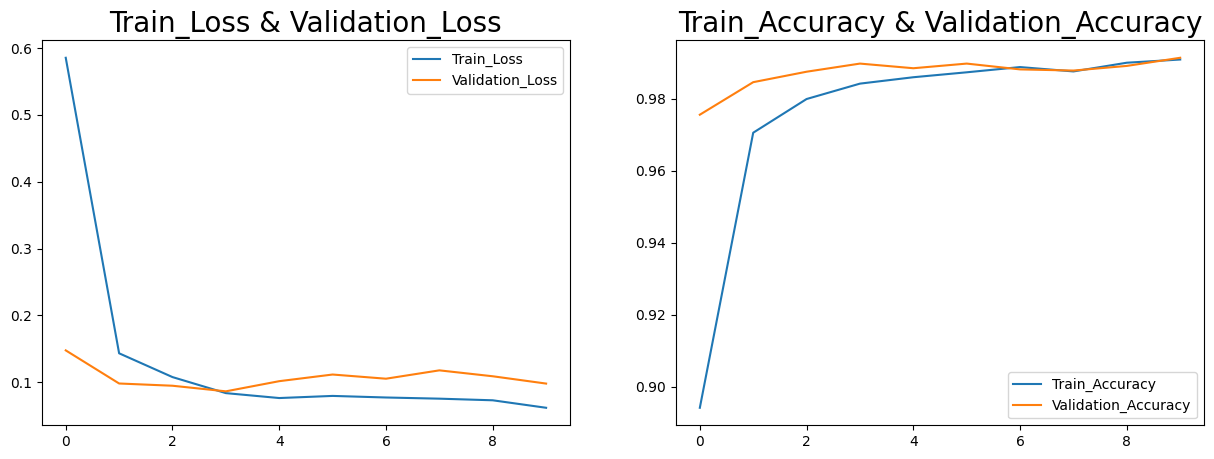

In [24]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(hist_['loss'],label='Train_Loss')
plt.plot(hist_['val_loss'],label='Validation_Loss')
plt.title('Train_Loss & Validation_Loss',fontsize=20)
plt.legend()
plt.subplot(1,2,2)
plt.plot(hist_['accuracy'],label='Train_Accuracy')
plt.plot(hist_['val_accuracy'],label='Validation_Accuracy')
plt.title('Train_Accuracy & Validation_Accuracy',fontsize=20)
plt.legend()

In [25]:

# Initialize empty lists
X_val, y_val, y_pred = [], [], []

# Iterate through the validation dataset
for images, labels in validation:
    y_val.extend(labels.numpy())
    X_val.append(images.numpy())

# Concatenate the list of arrays into a single array
X_val = np.concatenate(X_val)

# Predict using the model
predictions = keras_model.predict(X_val)

# Iterate through predictions and get the index of the maximum value
for i in predictions:
    y_pred.append(np.argmax(i))

# Create a DataFrame to store actual and predicted values
df = pd.DataFrame({'Actual': y_val, 'Prediction': y_pred})


97/97 [==============================] - 15s 75ms/step


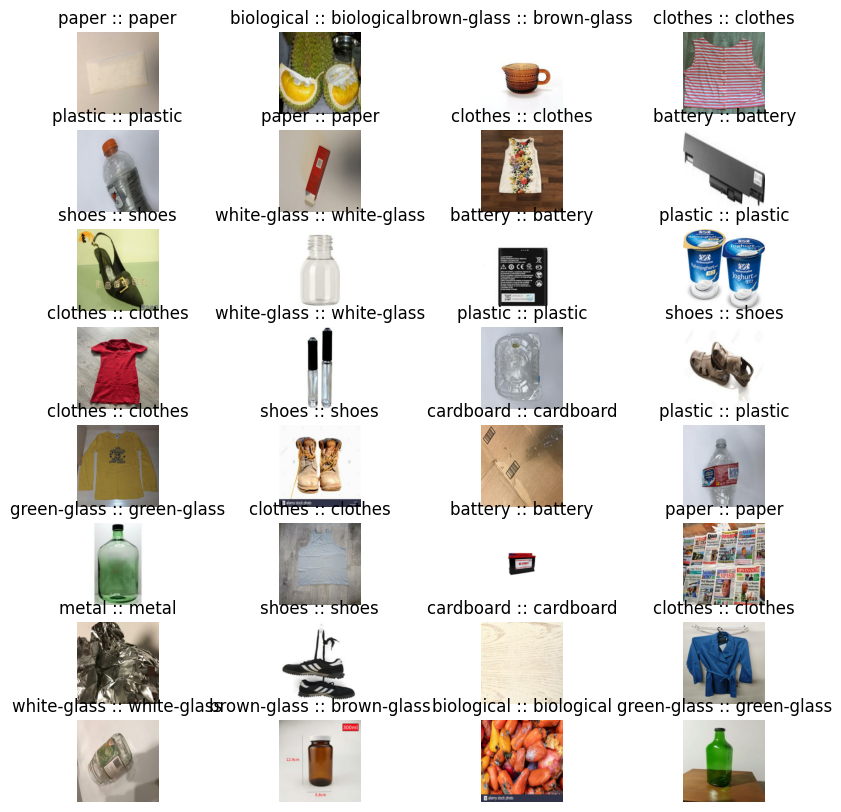

In [26]:
plt.figure(figsize=(10,10))
for i in range(32):
    ax = plt.subplot(8, 4, i + 1)
    plt.imshow(X_val[i].astype("uint8"))
    plt.title(f'{class_names[y_val[i]]} :: {class_names[y_pred[i]]}')
    plt.axis("off")

<a id="6"></a>
# **<center><span style="color:black;">Confusion Matrix</span></center>**

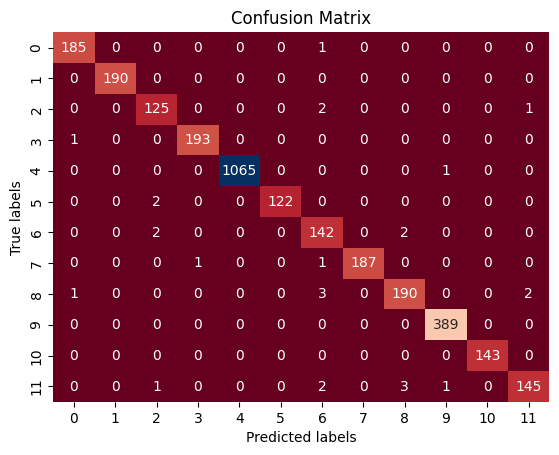

array([[ 185,    0,    0,    0,    0,    0,    1,    0,    0,    0,    0,
           0],
       [   0,  190,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,  125,    0,    0,    0,    2,    0,    0,    0,    0,
           1],
       [   1,    0,    0,  193,    0,    0,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    0,    0, 1065,    0,    0,    0,    0,    1,    0,
           0],
       [   0,    0,    2,    0,    0,  122,    0,    0,    0,    0,    0,
           0],
       [   0,    0,    2,    0,    0,    0,  142,    0,    2,    0,    0,
           0],
       [   0,    0,    0,    1,    0,    0,    1,  187,    0,    0,    0,
           0],
       [   1,    0,    0,    0,    0,    0,    3,    0,  190,    0,    0,
           2],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,  389,    0,
           0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,  143,
           0],
       [   0,    0,  

In [27]:
ax= plt.subplot()
CM = confusion_matrix(y_val,y_pred)
sns.heatmap(CM, annot=True, fmt='g', ax=ax,cbar=False,cmap='RdBu')
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
plt.show()
CM

<a id="7"></a>
# **<center><span style="color:black;">Accuracy</span></center>**

In [28]:
Acc = accuracy_score(y_val,y_pred)
print("accuracy is: {0:.4f}%".format(Acc * 100))

accuracy is: 99.1299%
